In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from lbg_forecast import emulator as em
from lbg_forecast import population_model as pop

In [2]:
bands = ["u"]#,"g","r","i","z","y"]

loss_bands = []
val_bands = []

for band in bands:
    loss = np.load("trained_models/loss_lsst_"+band+".npy")
    val = np.load("trained_models/valloss_lsst_"+band+".npy")

    loss_bands.append(loss)
    val_bands.append(val)

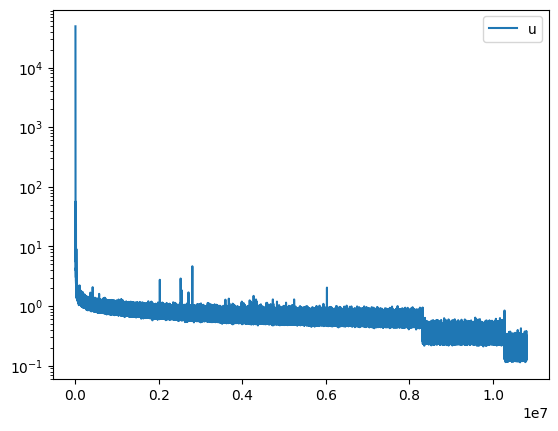

In [3]:
i = 0
for x in loss_bands:
    plt.plot(x, label=bands[i])
    i+=1

plt.yscale("log")
plt.legend()

0.16770224273204803


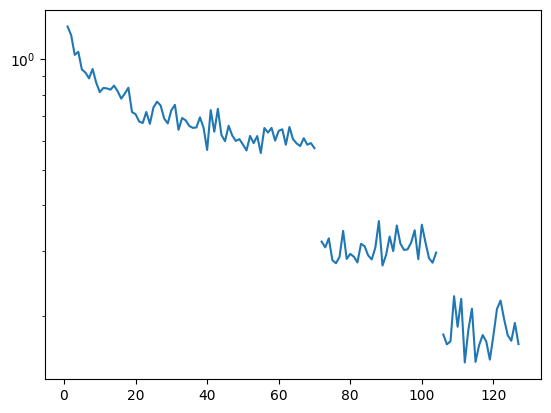

In [4]:
i = 0
for y in val_bands:
    plt.plot(y)
    print(y[-1])

plt.yscale("log")

In [5]:
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [6]:
sps_params_train = np.load("validation_data/sps_parameters_1200000.npy")
phot_train = np.load("validation_data/photometry_1200000.npy")

#def cut(z):
#    return 10**(z+4)

#band = 0

#z = sps_params_train[:, 0]
#mass = sps_params_train[:, -1]
#mag = phot_train[:, band]

#inds = np.where(mass > cut(z))[0]

#sps_params_train = sps_params_train[inds]
#phot_train = phot_train[inds]


/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


1200000
total outliers:  29.734083333333334


(3.631e-36, 3.6310000000000006e-24)

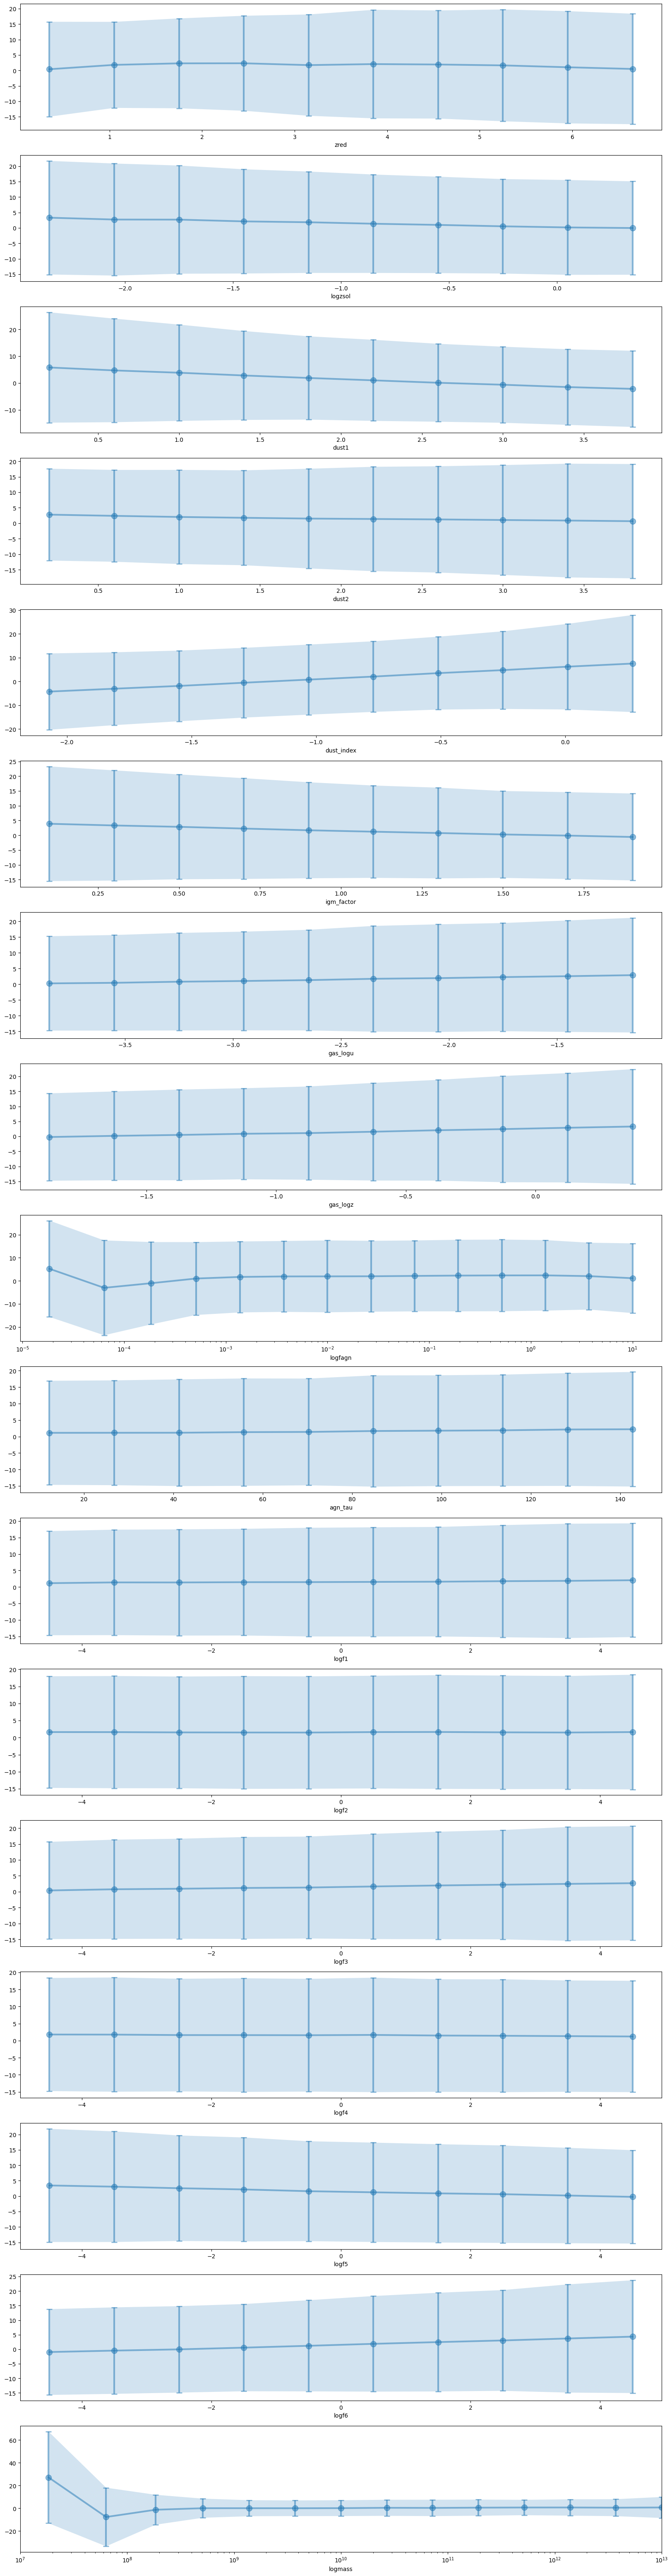

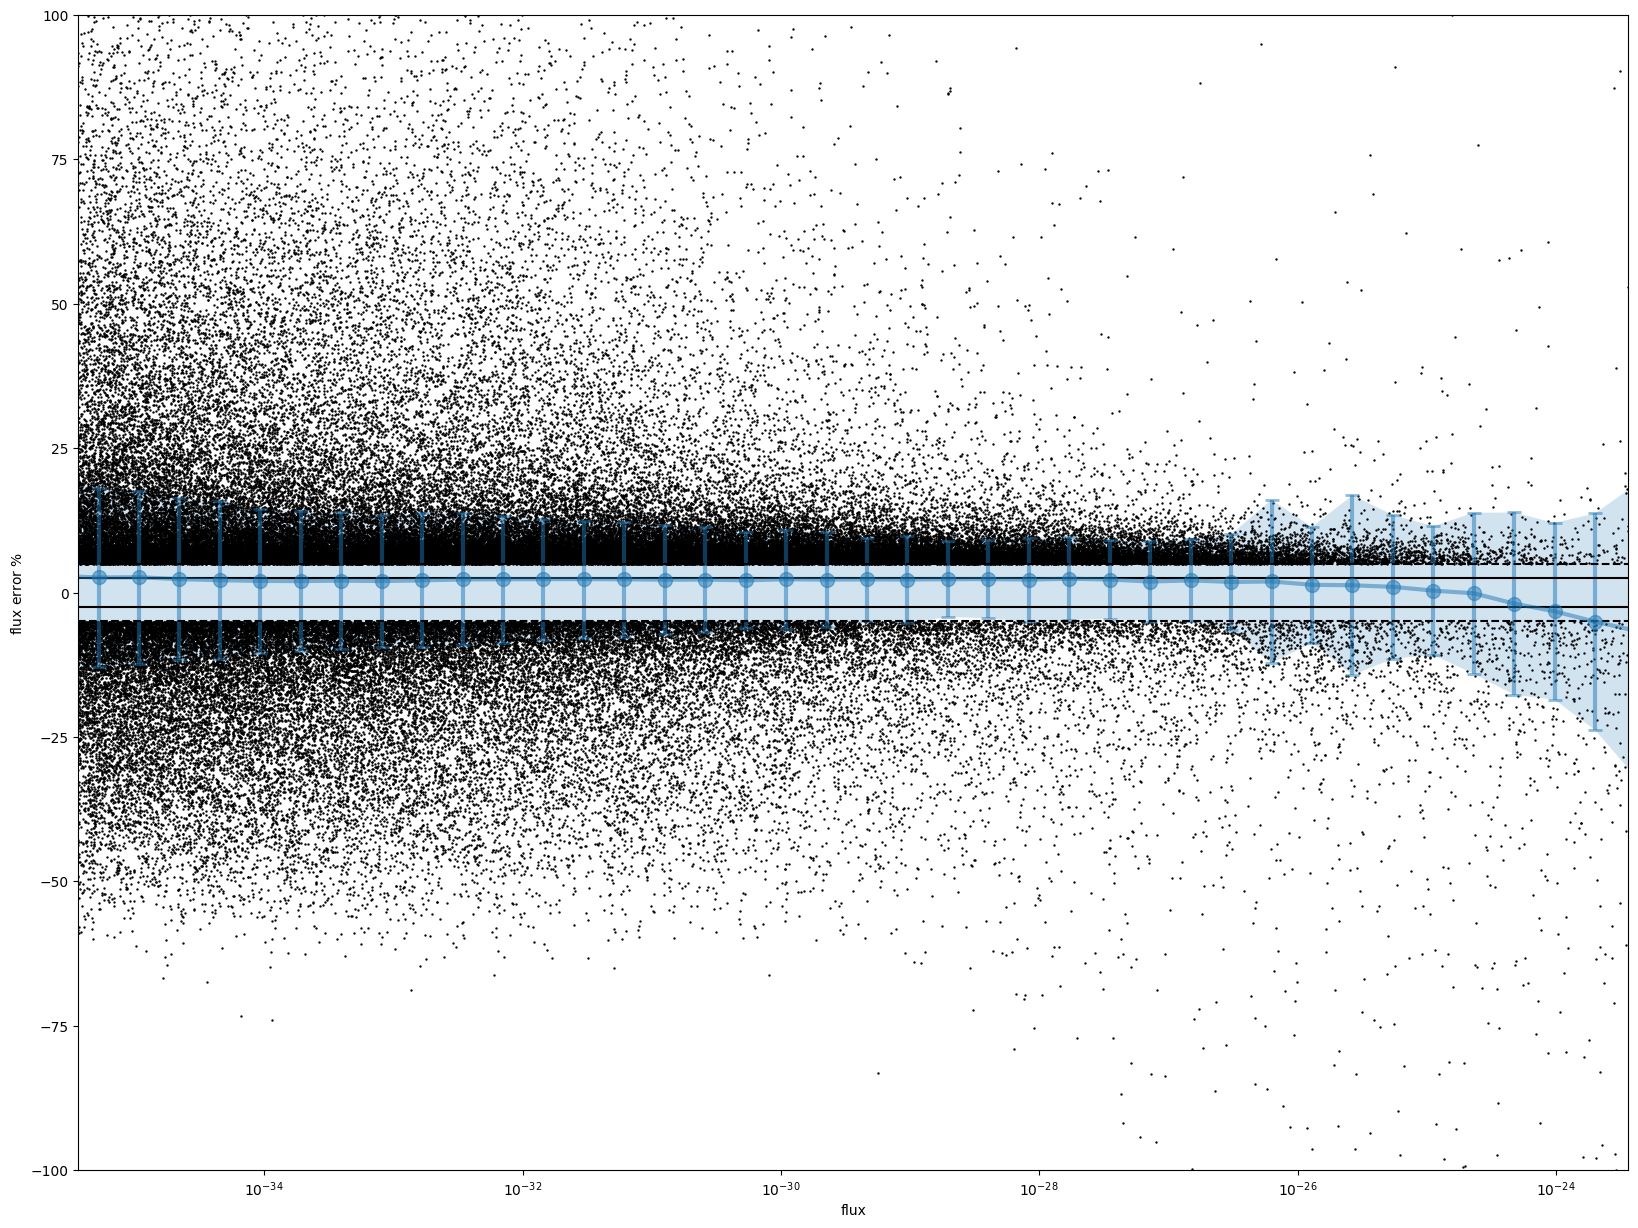

In [7]:
def mab_to_flux(mag):
    return 3.631e-20*10**(-(mag/2.5))


#mag_cut_upper = 30
#mag_cut_lower = 10
#inds = np.where((phot_train[:, 0] < mag_cut_upper) & (phot_train[:, 0] > mag_cut_lower))[0] #UBAND ONLY!!!!!!!!!!!!!!!!!!!!!!

#phot_train = phot_train[inds]
#sps_params_train = sps_params_train[inds, :]

nsamples=1200000
band = 0
#z_train = sps_params_train[:nsamples, 0]
#mass_train = sps_params_train[:nsamples, -1]
#mag = phot_train[:nsamples, band]

#inds = np.where(mass_train > cut(z_train))[0]

#sps_params_train = sps_params_train[inds]
#phot_train = phot_train[inds]

y_bound = 5.0
sps_params = sps_params_train[:nsamples, :]
m_mimic = mab_to_flux(model.mimic_photometry(sps_params[:,], batch_size=sps_params.shape[0]))
print(sps_params.shape[0])
m_true = mab_to_flux(phot_train[:nsamples, :])
nbands = 1 

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        dm = ((m_mimic[:, j]-m_true[:, j])/(m_true[:, j]))*100
        #axes[i].scatter(sps_params[:, i], dm[:,], alpha=alpha)
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std')
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)



fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'mean', np.logspace(-50, -19, 100))
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'std', np.logspace(-50, -19, 100))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

    inds = np.where(abs(dm) > y_bound)[0]
    dm_outliers = dm[inds]
    m_true_outliers = m_true[inds, np.ones_like(inds)*j]

    axes2.scatter(m_true[inds, np.ones_like(inds)*j], dm[inds], s=0.5, c='k')
    print("total outliers: ", (len(dm_outliers)/len(dm))*100)



axes2.set_xlabel('flux')
axes2.set_ylabel('flux error $\%$')
axes2.set_xscale('log')

axes2.axhline(y=y_bound, color='k', linestyle='--')
axes2.axhline(y=-y_bound, color='k', linestyle='--')

axes2.axhline(y=y_bound/2, color='k', linestyle='-')
axes2.axhline(y=-y_bound/2, color='k', linestyle='-')

#axes2.axhline(y=1, color='k', linestyle='-')
#axes2.axhline(y=-1, color='k', linestyle='-')

#axes2.axvline(x=10, color='k', linestyle='--')
#axes2.axvline(x=30, color='k', linestyle='--')

axes2.set_ylim(-100, 100)

axes2.set_xlim(mab_to_flux(40), mab_to_flux(10))


In [8]:
phot_train = np.load("validation_data/photometry_1200000.npy")
sps_params_train = np.load("validation_data/sps_parameters_1200000.npy")

#def cut(z):
#    return 10**(z+4)

#band = 0

#z = sps_params_train[:, 0]
#mass = sps_params_train[:, -1]
#mag = phot_train[:, band]

#inds = np.where(mass > cut(z))[0]

#sps_params_train = sps_params_train[inds]
#phot_train = phot_train[inds]

total outliers:  31.6655


(-1.5, 1.5)

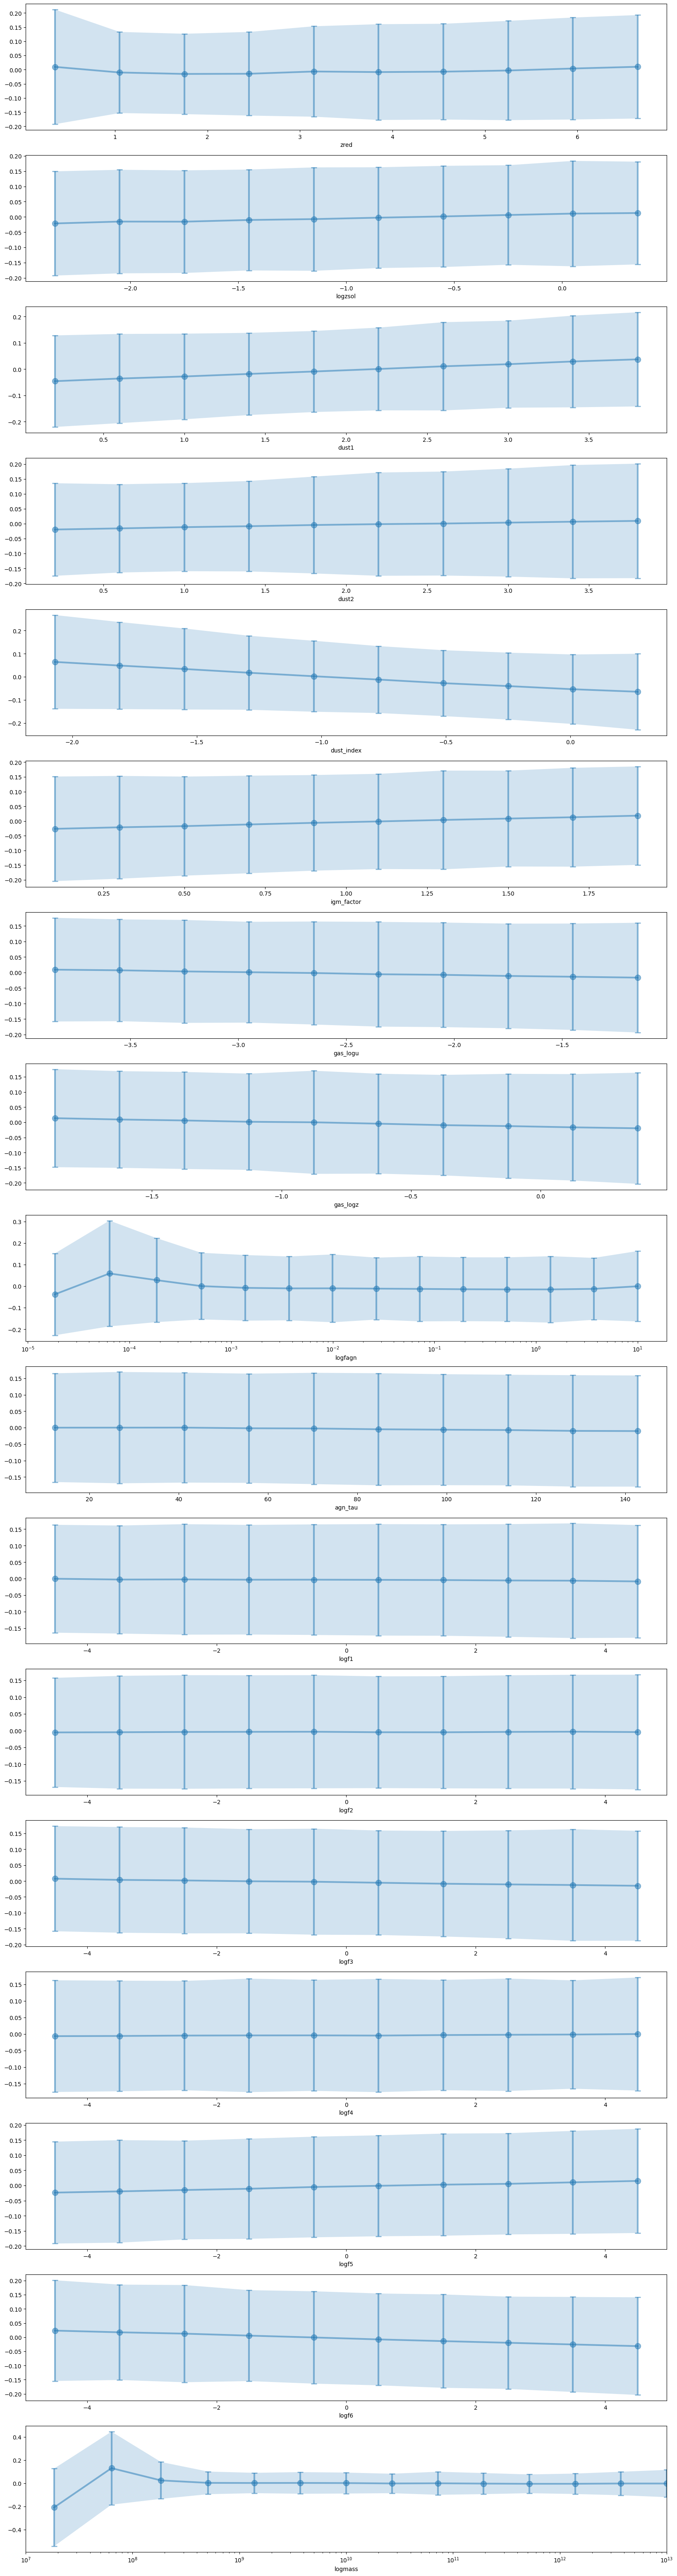

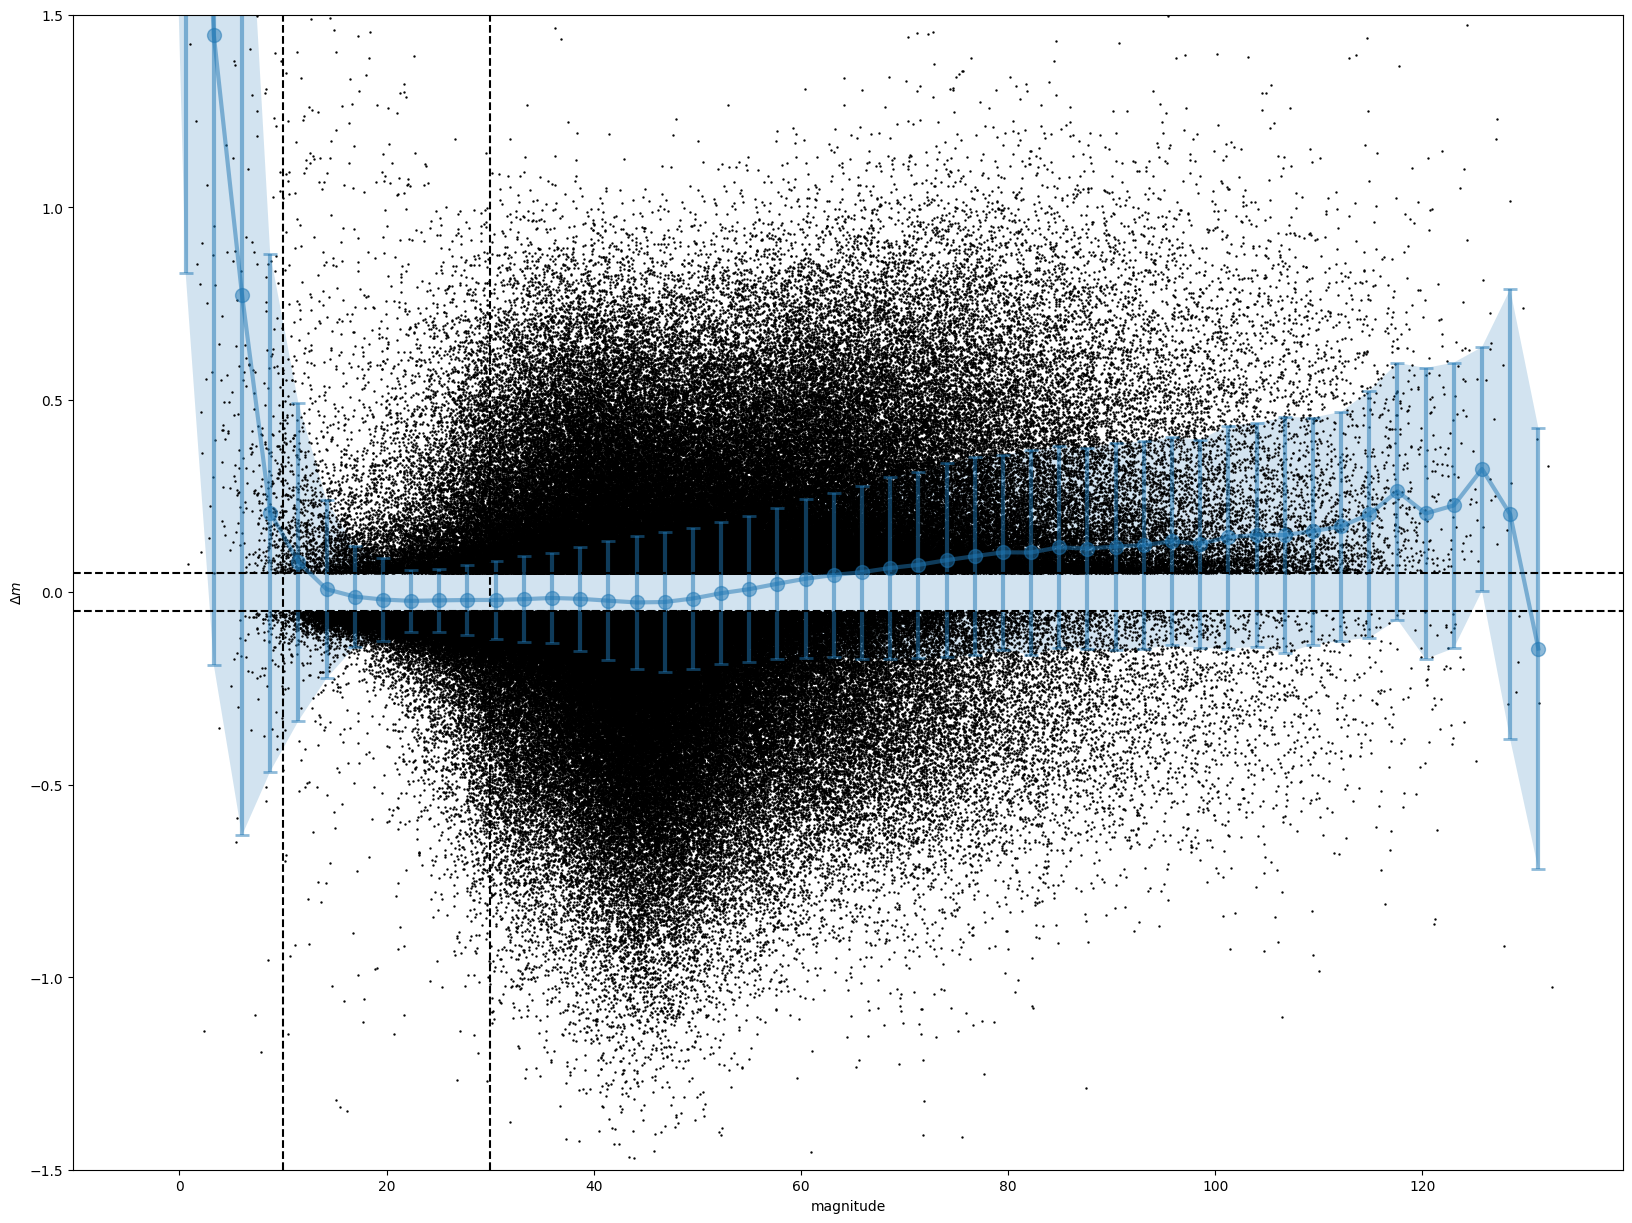

In [9]:
nsamples=1200000
y_bound = 0.05
sps_params = sps_params_train[:nsamples, :]
m_mimic = model.mimic_photometry(sps_params[:,], batch_size=sps_params.shape[0])
m_true = phot_train[:nsamples, :]
nbands = 1 

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        dm = m_mimic[:, j]-m_true[:, j]
        #axes[i].scatter(sps_params[:, i], dm[:,], alpha=alpha)
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std')
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)



fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'mean', 50)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'std', 50)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

    inds = np.where(abs(dm) > y_bound)[0]
    dm_outliers = dm[inds]
    m_true_outliers = m_true[inds, np.ones_like(inds)*j]

    axes2.scatter(m_true[inds, np.ones_like(inds)*j], dm[inds], s=0.5, c='k')
    print("total outliers: ", (len(dm_outliers)/len(dm))*100)



axes2.set_xlabel('magnitude')
axes2.set_ylabel('$\Delta m$')

axes2.axhline(y=y_bound, color='k', linestyle='--')
axes2.axhline(y=-y_bound, color='k', linestyle='--')

#axes2.axhline(y=0.1, color='k', linestyle='-')
#axes2.axhline(y=0.1, color='k', linestyle='-')

axes2.axvline(x=10, color='k', linestyle='--')
axes2.axvline(x=30, color='k', linestyle='--')

axes2.set_ylim(-1.5, 1.5)

#axes2.set_xlim(0, 40)


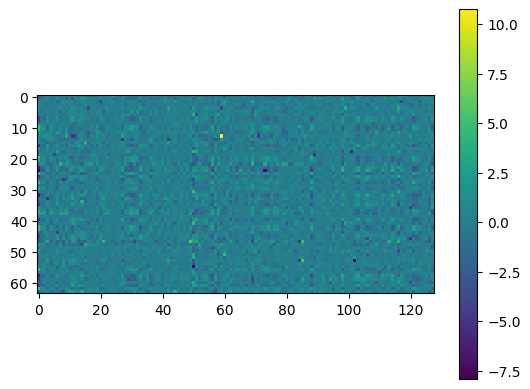

In [10]:
weights = model._models[0].W
biases = model._models[0].b
a = model._models[0].alphas
b = model._models[0].betas

layer = 5

weights[layer].shape

plt.imshow(np.transpose(weights[layer]))
plt.colorbar()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  4., 49.,  6.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.33914208, -0.30997986, -0.2808176 , -0.25165537, -0.22249313,
        -0.19333088, -0.16416864, -0.1350064 , -0.10584416, -0.07668193,
        -0.04751968, -0.01835744,  0.0108048 ,  0.03996704,  0.06912927,
         0.09829152,  0.12745376,  0.156616  ,  0.18577823,  0.21494047,
         0.24410272,  0.27326494,  0.3024272 ,  0.33158943,  0.36075169,
         0.38991392,  0.41907614,  0.4482384 ,  0.47740063,  0.50656289,
         0.53572512,  0.56488734,  0.59404957,  0.62321186,  0.65237409,
         0.68153632,  0.71069854,  0.73986077,  0.76902306,  0.79818529,
         0.82734752,  0.85650975,  0.88567197,  0.91483426,  0.94399649,
         0.97315872,  1.002321  ,  1.03148317,  1.06064546,

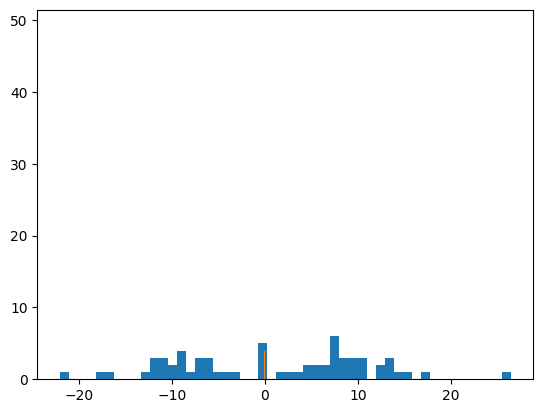

In [11]:
layer = 5

plt.hist(a[layer].numpy(), bins=50)
plt.hist(b[layer].numpy(), bins=50)

#plt.hist(a[layer])

(array([1., 0., 1., 0., 0., 0., 0., 0., 0., 3., 1., 0., 0., 1., 0., 0., 3.,
        3., 2., 0., 2., 1., 2., 3., 1., 3., 3., 2., 1., 2., 1., 1., 3., 0.,
        3., 3., 1., 5., 1., 1., 1., 1., 1., 2., 1., 1., 0., 1., 1., 1.]),
 array([-21.94797516, -21.18738937, -20.42680359, -19.6662178 ,
        -18.90563202, -18.14504623, -17.38446045, -16.62387466,
        -15.86328983, -15.10270405, -14.34211826, -13.58153248,
        -12.82094669, -12.06036091, -11.29977512, -10.53918934,
         -9.77860355,  -9.01801777,  -8.25743198,  -7.49684668,
         -6.73626089,  -5.97567511,  -5.2150898 ,  -4.45450401,
         -3.69391823,  -2.93333244,  -2.17274666,  -1.41216099,
         -0.65157533,   0.10901039,   0.86959612,   1.63018179,
          2.39076757,   3.15135312,   3.91193891,   4.67252445,
          5.43311024,   6.19369602,   6.95428181,   7.71486759,
          8.47545338,   9.23603916,   9.99662495,  10.75721073,
         11.51779556,  12.27838135,  13.03896713,  13.79955292,
      

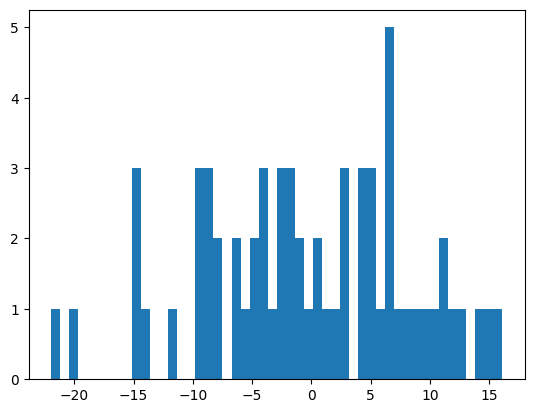

In [12]:
layer = 5

biases[layer].shape
plt.hist(biases[layer].numpy(), bins=50)